In [ ]:
!pip install oandapyV20

In [ ]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
import datetime

In [ ]:
client = oandapyV20.API(access_token="10fdf44033f5f4d97ef7e6b632325e3b-064d462be77f2f3d7833820ea9cf8c7b")

In [ ]:
def fetch_data(instrument="EUR_USD", granularity="H1", count=500):
    params = {
        "count": count,
        "granularity": granularity,
    }
    r = instruments.InstrumentsCandles(instrument=instrument, params=params)
    client.request(r)
    return r.response

In [ ]:
data = fetch_data()

In [ ]:
def process_data(data):
    candles = data['candles']
    df = pd.DataFrame([{
        'time': candle['time'],
        'open': float(candle['mid']['o']),
        'high': float(candle['mid']['h']),
        'low': float(candle['mid']['l']),
        'close': float(candle['mid']['c']),
        'volume': float(candle['volume'])
    } for candle in candles])

    # Convert time to a pandas datetime object and set it as index
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)

    return df

In [ ]:
df = process_data(data)

In [ ]:
pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.9 MB/s eta 0:00:00


In [ ]:
import mplfinance as mpf

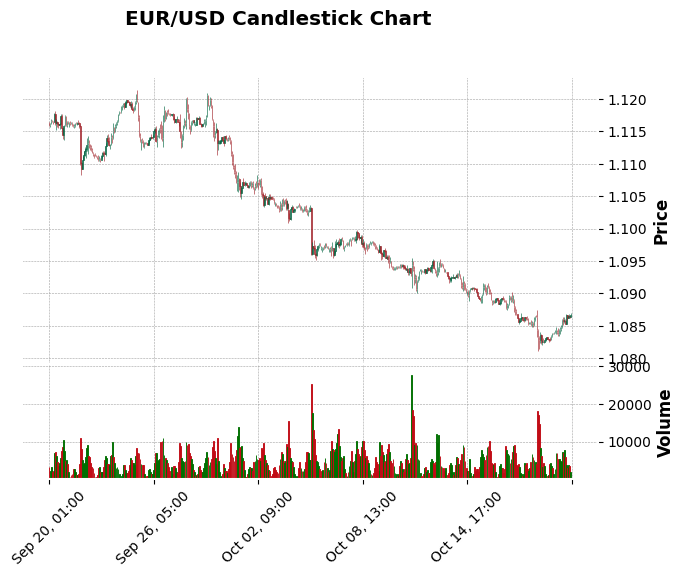

In [ ]:
mpf.plot(df, type='candle', style='charles', title='EUR/USD Candlestick Chart', ylabel='Price', volume=True)

EMA

In [ ]:
df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA40'] = df['close'].ewm(span=40, adjust=False).mean()

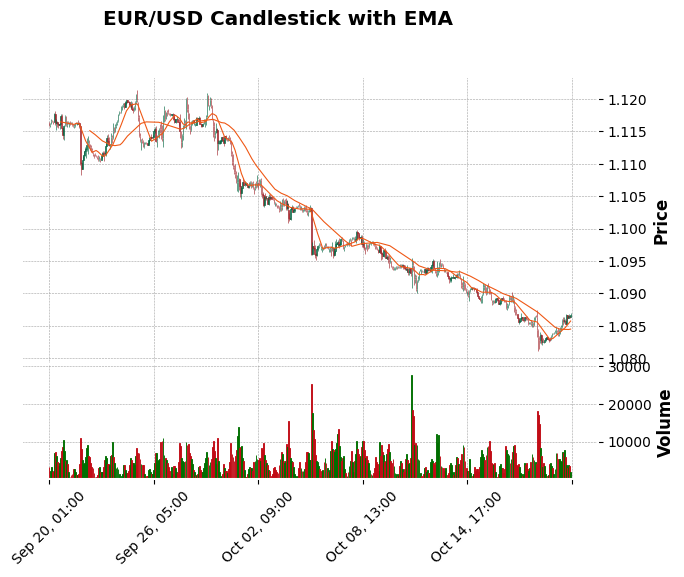

In [ ]:
mpf.plot(df, type='candle', style='charles', title='EUR/USD Candlestick with EMA',
         ylabel='Price', volume=True, mav=(12, 40))

RSI

In [ ]:
def calculate_rsi(df, period=14):
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [ ]:
df['RSI'] = calculate_rsi(df)

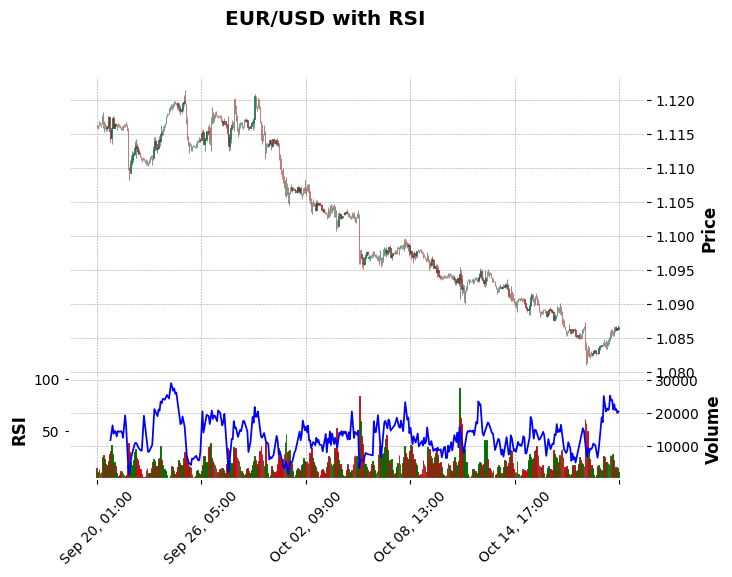

In [ ]:
apds = [mpf.make_addplot(df['RSI'], panel=1, color='blue', ylabel='RSI')]
mpf.plot(df, type='candle', style='charles', title='EUR/USD with RSI',
         ylabel='Price', volume=True, addplot=apds, panel_ratios=(6, 2))

Signal/Preprocessing

In [ ]:
import numpy as np

In [ ]:
df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA40'] = df['close'].ewm(span=40, adjust=False).mean()
df['EMA_crossover'] = np.where(df['EMA12'] > df['EMA40'], 1, -1)  # 1 for bullish crossover, -1 for bearish crossover
df['RSI'] = calculate_rsi(df)

In [ ]:
df['future_price'] = df['close'].shift(-1)
df['price_change'] = (df['future_price'] - df['close']) / df['close']

In [ ]:
df['target'] = np.where(df['price_change'] > 0, 1, 0)

In [ ]:
df.dropna(inplace=True)

In [ ]:
features = df[['EMA_crossover', 'RSI']]
target = df['target']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Logistic Regression Model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)
log_accuracy = accuracy_score(y_test, log_preds)
print(f"Logistic Regression Accuracy: {log_accuracy:.4f}")

Logistic Regression Accuracy: 0.5510


In [ ]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Random Forest Accuracy: 0.5510


In [ ]:
# XGBoost Model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_preds)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

XGBoost Accuracy: 0.5816


In [ ]:
from sklearn.metrics import classification_report
# Logistic Regression Evaluation
print("Logistic Regression Report:")
print(classification_report(y_test, log_preds))
# Random Forest Evaluation
print("Random Forest Report:")
print(classification_report(y_test, rf_preds))
# XGBoost Evaluation
print("XGBoost Report:")
print(classification_report(y_test, xgb_preds))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.54      0.98      0.70        52
           1       0.75      0.07      0.12        46

    accuracy                           0.55        98
   macro avg       0.65      0.52      0.41        98
weighted avg       0.64      0.55      0.43        98

Random Forest Report:
              precision    recall  f1-score   support

           0       0.57      0.62      0.59        52
           1       0.52      0.48      0.50        46

    accuracy                           0.55        98
   macro avg       0.55      0.55      0.55        98
weighted avg       0.55      0.55      0.55        98

XGBoost Report:
              precision    recall  f1-score   support

           0       0.60      0.65      0.62        52
           1       0.56      0.50      0.53        46

    accuracy                           0.58        98
   macro avg       0.58      0.58      0.58        98
weighted

In [ ]:
print(df['target'].value_counts())

target
0    254
1    232
Name: count, dtype: int64


Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification

In [ ]:
base_models = [
    ('logistic', LogisticRegression(max_iter=1000)),
    ('random_forest', RandomForestClassifier(n_estimators=100)),
    ('xgboost', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
]

In [ ]:
meta_model = RandomForestClassifier(n_estimators=100)
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

In [ ]:
stacking_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:43:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:43:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:43:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:43:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:43:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

StackingClassifier(cv=5,
                   estimators=[('logistic', LogisticRegression(max_iter=1000)),
                               ('random_forest', RandomForestClassifier()),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              f...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=RandomForestClassifier())

In [ ]:
stacking_preds = stacking_clf.predict(X_test)

In [ ]:
print("Classification Report for Stacking Classifier:")
print(classification_report(y_test, stacking_preds))

Classification Report for Stacking Classifier:
              precision    recall  f1-score   support

           0       0.56      0.69      0.62        52
           1       0.53      0.39      0.45        46

    accuracy                           0.55        98
   macro avg       0.55      0.54      0.54        98
weighted avg       0.55      0.55      0.54        98



In [ ]:
from sklearn.metrics import f1_score

In [ ]:
log_f1 = f1_score(y_test, log_preds)
rf_f1 = f1_score(y_test, rf_preds)
xgb_f1 = f1_score(y_test, xgb_preds)
stacking_f1 = f1_score(y_test, stacking_preds)

In [ ]:
f1_scores = {
    'Logistic Regression': log_f1,
    'Random Forest': rf_f1,
    'XGBoost': xgb_f1,
    'Stacking Classifier': stacking_f1
}

In [ ]:
for model_name, f1 in f1_scores.items():
    print(f"{model_name} F1 Score: {f1:.4f}")

Logistic Regression F1 Score: 0.1200
Random Forest F1 Score: 0.5000
XGBoost F1 Score: 0.5287
Stacking Classifier F1 Score: 0.4500


fetch historical data and backtest

In [ ]:
def fetch_live_data(instrument="EUR_USD", granularity="H1", count=100):
    params = {
        "count": count,
        "granularity": granularity
    }
    r = instruments.InstrumentsCandles(instrument=instrument, params=params)
    client.request(r)
    return r.response

In [ ]:
def process_data(data):
    candles = data['candles']
    df_backtest = pd.DataFrame([{
        'time': candle['time'],
        'open': float(candle['mid']['o']),
        'high': float(candle['mid']['h']),
        'low': float(candle['mid']['l']),
        'close': float(candle['mid']['c']),
        'volume': float(candle['volume'])
    } for candle in candles])

    df_backtest['time'] = pd.to_datetime(df_backtest['time'])
    df_backtest.set_index('time', inplace=True)
    return df_backtest

In [ ]:
df_backtest = process_data(fetch_data())

In [ ]:
df_backtest['EMA12'] = df_backtest['close'].ewm(span=12, adjust=False).mean()
df_backtest['EMA40'] = df_backtest['close'].ewm(span=40, adjust=False).mean()

def calculate_rsi(df, period=14):
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_backtest['RSI'] = calculate_rsi(df_backtest)

In [ ]:
df_backtest['EMA_crossover'] = np.where(df_backtest['EMA12'] > df_backtest['EMA40'], 1, -1)
df_backtest['future_price'] = df_backtest['close'].shift(-1)
df_backtest['price_change'] = (df_backtest['future_price'] - df_backtest['close']) / df_backtest['close']
df_backtest['target'] = np.where(df_backtest['price_change'] > 0, 1, 0)
df_backtest.dropna(inplace=True)

In [ ]:
features = df_backtest[['EMA_crossover', 'RSI']]
target = df_backtest['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
base_models = [
    ('logistic', LogisticRegression(max_iter=1000)),
    ('random_forest', RandomForestClassifier(n_estimators=100)),
    ('xgboost', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
]
meta_model = RandomForestClassifier(n_estimators=100)
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

In [ ]:
stacking_clf.fit(X_train, y_train)
stacking_preds = stacking_clf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:03:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:03:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:03:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:03:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:03:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

In [ ]:
stacking_accuracy = accuracy_score(y_test, stacking_preds)
print(f"Stacking Classifier Accuracy: {stacking_accuracy:.4f}")
print("Classification Report for Stacking Classifier:")
print(classification_report(y_test, stacking_preds))

Stacking Classifier Accuracy: 0.5816
Classification Report for Stacking Classifier:
              precision    recall  f1-score   support

           0       0.59      0.67      0.63        52
           1       0.56      0.48      0.52        46

    accuracy                           0.58        98
   macro avg       0.58      0.58      0.57        98
weighted avg       0.58      0.58      0.58        98



In [ ]:
initial_capital = 5000
capital = initial_capital
risk_percent = 0.03  # 3% risk
risk_reward_ratio = 2  # 1:2 risk-reward ratio
close_prices = df_backtest['close'].values
profits = []
losses = []

In [ ]:
# Backtest using predictions from the stacking model
for i, prediction in enumerate(stacking_preds):
    if i >= len(close_prices) - 1:
        break

    trade_risk = capital * risk_percent
    take_profit = trade_risk * risk_reward_ratio
    current_price = close_prices[i]
    stop_loss = current_price - (trade_risk / capital) * current_price
    take_profit_level = current_price + (take_profit / capital) * current_price
    future_price = close_prices[i + 1]

In [ ]:
# Backtest using predictions from the stacking model
for i, prediction in enumerate(stacking_preds):
    if i >= len(close_prices) - 1:
        break

    trade_risk = capital * risk_percent
    take_profit = trade_risk * risk_reward_ratio
    current_price = close_prices[i]
    stop_loss = current_price - (trade_risk / capital) * current_price
    take_profit_level = current_price + (take_profit / capital) * current_price
    future_price = close_prices[i + 1]

    # Buy Signal
    if prediction == 1:
        if future_price >= take_profit_level:
            capital += take_profit
            profits.append(take_profit)
        elif future_price <= stop_loss:
            capital -= trade_risk
            losses.append(trade_risk)

    # Sell Signal
    elif prediction == 0:
        if future_price <= take_profit_level:
            capital += take_profit
            profits.append(take_profit)
        elif future_price >= stop_loss:
            capital -= trade_risk
            losses.append(trade_risk)

In [ ]:
final_profit = capital - initial_capital
profit_percent = (final_profit / initial_capital) * 100
print(f"Initial Capital: ${initial_capital}")
print(f"Final Capital: ${capital:.2f}")
print(f"Total Profit: ${final_profit:.2f}")
print(f"Profit Percentage: {profit_percent:.2f}%")
print(f"Total Trades: {len(stacking_preds)}")
print(f"Winning Trades: {len(profits)}")
print(f"Losing Trades: {len(losses)}")

Initial Capital: $5000
Final Capital: $155602.32
Total Profit: $150602.32
Profit Percentage: 3012.05%
Total Trades: 98
Winning Trades: 59
Losing Trades: 0


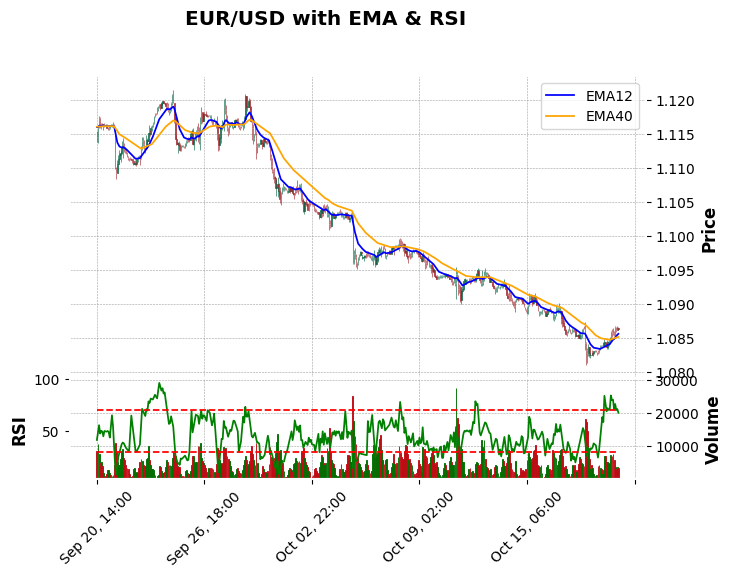

In [ ]:
# Visualization: Candlestick chart with EMA and RSI, including RSI boundaries at 70 and 30
apds = [
    mpf.make_addplot(df_backtest['EMA12'], color='blue', label='EMA12'),
    mpf.make_addplot(df_backtest['EMA40'], color='orange', label='EMA40'),
    mpf.make_addplot(df_backtest['RSI'], panel=1, color='green', ylabel='RSI'),

    # Add horizontal lines for RSI overbought/oversold levels
    mpf.make_addplot([70]*len(df_backtest), panel=1, color='red', linestyle='dashed'),  # Overbought level
    mpf.make_addplot([30]*len(df_backtest), panel=1, color='red', linestyle='dashed'),  # Oversold level
]

# Plot the chart
mpf.plot(df_backtest, type='candle', style='charles', title='EUR/USD with EMA & RSI',
         ylabel='Price', volume=True, addplot=apds, panel_ratios=(6, 2))

Deployment

In [ ]:
import oandapyV20
from oandapyV20.endpoints.orders import OrderCreate
from oandapyV20.endpoints.pricing import PricingInfo
import json
import time

In [ ]:
client = oandapyV20.API(access_token='10fdf44033f5f4d97ef7e6b632325e3b-064d462be77f2f3d7833820ea9cf8c7b')
account_id = '101-001-30143451-001'

In [ ]:
def place_order(instrument, units, stop_loss_price, take_profit_price, order_type='MARKET'):
    data = {
        "order": {
            "instrument": instrument,
            "units": units,
            "type": order_type,
            "timeInForce": "FOK",
            "stopLossOnFill": {"price": str(round(stop_loss_price, 5))},
            "takeProfitOnFill": {"price": str(round(take_profit_price, 5))}
        }
    }
    r = OrderCreate(accountID=account_id, data=data)
    client.request(r)
    print(json.dumps(r.response, indent=4))

In [ ]:
# Function to fetch real-time price from OANDA
def fetch_real_time_price(instrument="EUR_USD"):
    params = {"instruments": instrument}
    r = PricingInfo(accountID=account_id, params=params)
    client.request(r)
    prices = r.response['prices'][0]
    return float(prices['closeoutBid']), float(prices['closeoutAsk'])

In [ ]:
# Risk management function to calculate stop-loss and take-profit levels
def calculate_risk_management(current_price, risk_percent=0.03, reward_ratio=2):
    stop_loss = current_price * (1 - risk_percent)
    take_profit = current_price * (1 + (risk_percent * reward_ratio))
    return stop_loss, take_profit

In [ ]:
# Function to get the latest features for model prediction
def get_live_features(df):
    features_live = df[['EMA_crossover', 'RSI']].tail(1)  # Use most recent row
    features_live = features_live.apply(pd.to_numeric, errors='coerce').fillna(0).values.flatten()
    return features_live

In [ ]:
# Continuous Monitoring and Automated Trading Loop
def automated_trading_loop():
    while True:
        # Fetch the real-time price of EUR/USD
        bid, ask = fetch_real_time_price()
        current_price = (bid + ask) / 2

        # Extract live features from the most recent data in df_backtest
        features_live = get_live_features(df_backtest)

        # Make prediction based on your stacking model
        prediction = stacking_clf.predict([features_live])

        # Define stop-loss and take-profit levels
        stop_loss, take_profit = calculate_risk_management(current_price)

        # Execute buy/sell based on the prediction
        if prediction == 1:  # Buy Signal
            print(f"Buying EUR/USD at {current_price}")
            place_order("EUR_USD", units=1000, stop_loss_price=stop_loss, take_profit_price=take_profit)
        elif prediction == 0:  # Sell Signal
            print(f"Selling EUR/USD at {current_price}")
            place_order("EUR_USD", units=-1000, stop_loss_price=stop_loss, take_profit_price=take_profit)

        # Wait for an hour before checking again (1-hour timeframe)
        time.sleep(3600)